# Day 7: Statistics Interview Questions & Practice
## Week 2: Statistics & Probability for Finance

---

### 🎯 Today's Focus
- Common interview questions on statistics
- Brain teasers and probability puzzles
- Practical coding challenges
- Review of Week 2 concepts

---

### 📈 Why Statistics Interview Practice Matters

**Statistics in Quant Interviews:**

Statistics questions appear in nearly every quant finance interview. Interviewers test:

| What They Test | Why It Matters |
|----------------|----------------|
| Distribution knowledge | Risk measurement accuracy |
| Hypothesis testing | Strategy validation |
| Correlation concepts | Portfolio construction |
| Statistical inference | Backtest interpretation |

### Week 2 Topics in Interview Context

| Topic | Interview Frequency | Key Questions |
|-------|---------------------|---------------|
| Normality testing | Very High | "Are returns normal? How do you test?" |
| Sharpe inference | High | "Is this Sharpe ratio significant?" |
| Correlation | Very High | "What happens to correlation in crashes?" |
| Bayesian thinking | Medium | "How do you update beliefs with new data?" |

### How to Ace Statistics Questions

| Strategy | Implementation |
|----------|----------------|
| **State assumptions** | "Assuming returns are IID..." |
| **Show formula** | Write out the test statistic |
| **Give intuition** | "This measures..." |
| **Discuss limitations** | "This breaks down when..." |

In [1]:
# Day 7 Setup: Week 2 Review - Interview Questions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("WEEK 2 REVIEW: INTERVIEW QUESTIONS - DAY 7")
print("=" * 60)
print(f"\n✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
WEEK 2 REVIEW: INTERVIEW QUESTIONS - DAY 7

✅ Data loaded: 1254 days


---
## Question 1: Distribution Analysis

**"You have daily returns for a stock. How would you determine if they follow a Normal distribution? What are the implications if they don't?"**

| Autocorrelation | Momentum or mean-reversion strategies |

### How to Structure Your Answer| Negative skew | Crashes more severe than rallies |

| Fat tails | 99% VaR using Normal underestimates risk |

| Part | What to Say ||---------------------------|-------------------|

|------|-------------|| If Returns are Non-Normal | Impact on Trading |

| **Tests to Use** | Jarque-Bera (most common), Shapiro-Wilk, Q-Q plots |

| **Key Statistics** | Skewness (asymmetry), Kurtosis (fat tails) |### Trading Implications (The "So What?")

| **Trading Impact** | VaR underestimation, option mispricing |

| Kurtosis | 3 (or 0 excess) | 5-10+ | Fat tails, more extremes |

### The Key Statistics to Mention| Skewness | 0 | Negative (-0.3) | More extreme down moves |

|-----------|--------------|-----------------|--------|
| Statistic | Normal Value | Typical Returns | Meaning |

QUESTION 1: Testing Normality of Returns

1. FORMAL TESTS:
   Shapiro-Wilk:      p = 6.03e-21 ✗ Not Normal
   D'Agostino-Pearson: p = 5.89e-49 ✗ Not Normal
   Jarque-Bera:       p = 0.00e+00 ✗ Not Normal

2. DESCRIPTIVE STATISTICS:
   Skewness:  0.468 (Normal = 0)
   Kurtosis:  6.734 (Normal = 0, excess)

3. IMPLICATIONS IF NOT NORMAL:
   - VaR calculations using Normal assumption will underestimate risk
   - Option pricing models (Black-Scholes) may be inaccurate
   - Mean-variance optimization may be suboptimal
   - Use Student-t, Historical simulation, or EVT instead


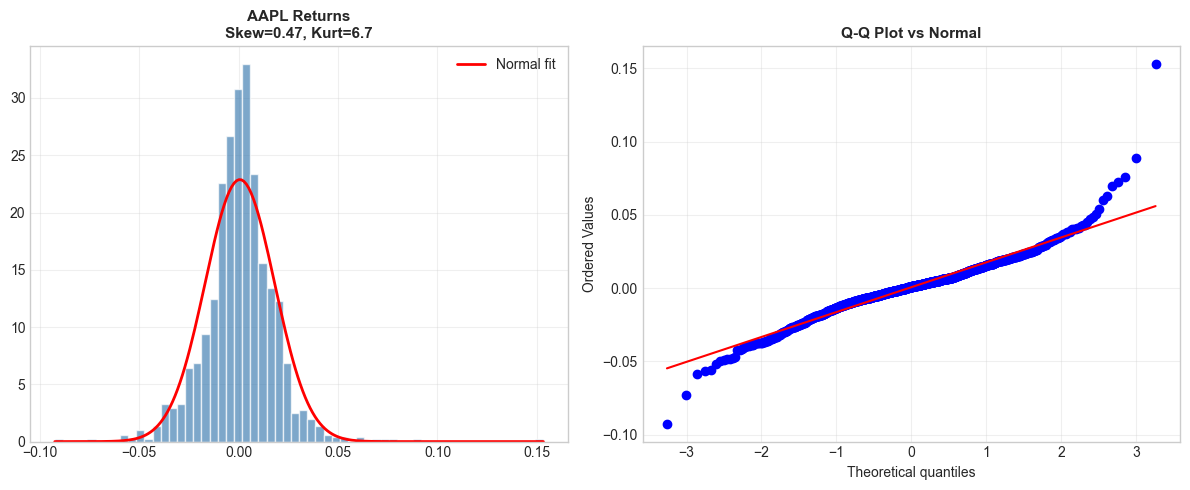

In [2]:
# ANSWER: Testing Normality
print("=" * 60)
print("QUESTION 1: Testing Normality of Returns")
print("=" * 60)

aapl_ret = returns['AAPL'].values

# Multiple tests for normality
# 1. Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(aapl_ret[:5000])  # Limited sample

# 2. D'Agostino-Pearson test
dagostino_stat, dagostino_p = stats.normaltest(aapl_ret)

# 3. Jarque-Bera test
jb_stat, jb_p = stats.jarque_bera(aapl_ret)

# 4. Visual: Skewness and Kurtosis
skewness = stats.skew(aapl_ret)
kurtosis = stats.kurtosis(aapl_ret)

print(f"\n1. FORMAL TESTS:")
print(f"   Shapiro-Wilk:      p = {shapiro_p:.2e} {'✗ Not Normal' if shapiro_p < 0.05 else '✓'}")
print(f"   D'Agostino-Pearson: p = {dagostino_p:.2e} {'✗ Not Normal' if dagostino_p < 0.05 else '✓'}")
print(f"   Jarque-Bera:       p = {jb_p:.2e} {'✗ Not Normal' if jb_p < 0.05 else '✓'}")

print(f"\n2. DESCRIPTIVE STATISTICS:")
print(f"   Skewness:  {skewness:.3f} (Normal = 0)")
print(f"   Kurtosis:  {kurtosis:.3f} (Normal = 0, excess)")

print(f"\n3. IMPLICATIONS IF NOT NORMAL:")
print("   - VaR calculations using Normal assumption will underestimate risk")
print("   - Option pricing models (Black-Scholes) may be inaccurate")
print("   - Mean-variance optimization may be suboptimal")
print("   - Use Student-t, Historical simulation, or EVT instead")

# Visual
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram with Normal fit
axes[0].hist(aapl_ret, bins=60, density=True, alpha=0.7, color='steelblue', edgecolor='white')
x = np.linspace(aapl_ret.min(), aapl_ret.max(), 200)
axes[0].plot(x, stats.norm.pdf(x, np.mean(aapl_ret), np.std(aapl_ret)), 'r-', lw=2, label='Normal fit')
axes[0].set_title(f'AAPL Returns\nSkew={skewness:.2f}, Kurt={kurtosis:.1f}', fontsize=11, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(aapl_ret, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot vs Normal', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Question 2: Sharpe Ratio Inference

**"A backtest shows a Sharpe ratio of 1.5 over 2 years. How confident are you that the true Sharpe is above 1.0?"**

| "Multiple strategies?" | Need Bonferroni correction |

### How to Structure Your Answer| "What about annualization?" | SR_annual = SR_daily × √252 |

| "How much data do you need?" | For SR=1, need ~5 years for significance |

| Part | What to Say ||-----------|-------------|

|------|-------------|| Follow-up | Your Answer |

| **Key Insight** | Sharpe ratios have standard errors! |

| **Formula** | SE(SR) ≈ √((1 + 0.5×SR²)/n) × √252 |### Interview Follow-ups to Expect

| **Approach** | Construct confidence interval |

- This is why live trading often disappoints vs backtest

### Why This Question Matters- True SR could plausibly be below 1.0!

- 95% CI is roughly [0.87, 2.13]

| Sample Period | SE of Sharpe | 95% CI Width |**With 2 years of data and SR = 1.5:**

|---------------|--------------|-------------|

| 1 year | ~0.45 | ±0.88 |### Trading Reality Check

| 2 years | ~0.32 | ±0.63 |
| 5 years | ~0.20 | ±0.39 |

QUESTION 2: Sharpe Ratio Confidence

Observed Sharpe: 1.5
Sample size: 504 days (2 years)

Standard Error of Sharpe: 1.031
95% Confidence Interval: [-0.52, 3.52]

Test: H0: True SR ≤ 1.0
z-statistic: 0.49
p-value: 0.3138

Conclusion: Cannot reject H0
Confidence that true SR > 1.0: 68.6%


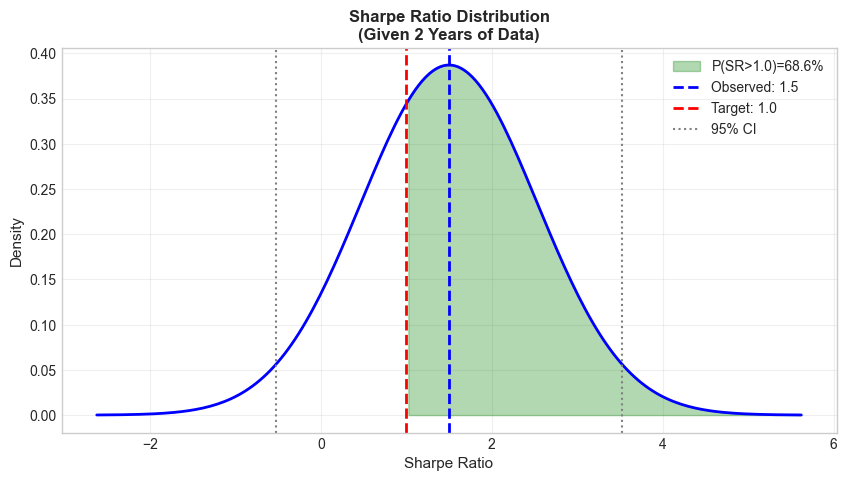

In [3]:
# ANSWER: Sharpe Ratio Inference
print("=" * 60)
print("QUESTION 2: Sharpe Ratio Confidence")
print("=" * 60)

# Given parameters
observed_sharpe = 1.5
n_years = 2
n_days = int(n_years * 252)

# Standard error of Sharpe ratio (approximation)
# SE(SR) ≈ sqrt((1 + 0.5*SR^2) / n)
se_sharpe = np.sqrt((1 + 0.5 * observed_sharpe**2) / n_days) * np.sqrt(252)

# Test H0: SR <= 1.0
target_sharpe = 1.0
z_stat = (observed_sharpe - target_sharpe) / se_sharpe
p_value = 1 - stats.norm.cdf(z_stat)

# Confidence interval
ci_lower = observed_sharpe - 1.96 * se_sharpe
ci_upper = observed_sharpe + 1.96 * se_sharpe

print(f"\nObserved Sharpe: {observed_sharpe}")
print(f"Sample size: {n_days} days ({n_years} years)")
print(f"\nStandard Error of Sharpe: {se_sharpe:.3f}")
print(f"95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"\nTest: H0: True SR ≤ 1.0")
print(f"z-statistic: {z_stat:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"\nConclusion: {'Can reject H0 - likely SR > 1' if p_value < 0.05 else 'Cannot reject H0'}")
print(f"Confidence that true SR > 1.0: {(1-p_value)*100:.1f}%")

# Visual
fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(observed_sharpe - 4*se_sharpe, observed_sharpe + 4*se_sharpe, 200)
ax.plot(x, stats.norm.pdf(x, observed_sharpe, se_sharpe), 'b-', lw=2)
ax.fill_between(x, stats.norm.pdf(x, observed_sharpe, se_sharpe), 
                where=x >= target_sharpe, alpha=0.3, color='green', label=f'P(SR>1.0)={1-p_value:.1%}')
ax.axvline(observed_sharpe, color='blue', lw=2, linestyle='--', label=f'Observed: {observed_sharpe}')
ax.axvline(target_sharpe, color='red', lw=2, linestyle='--', label=f'Target: {target_sharpe}')
ax.axvline(ci_lower, color='gray', lw=1.5, linestyle=':')
ax.axvline(ci_upper, color='gray', lw=1.5, linestyle=':', label='95% CI')
ax.set_xlabel('Sharpe Ratio', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Sharpe Ratio Distribution\n(Given 2 Years of Data)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

---
## Question 3: Correlation Problem

**"Two stocks have a correlation of 0.8 during normal markets. What would you expect during a crash?"**

| "What about VaR?" | Use stress-test correlations, not historical |

### How to Structure Your Answer| "How to hedge?" | Use tail hedges (puts), not just correlation |

| "How do you model this?" | Regime-switching models, copulas |

| Part | What to Say ||-----------|-------------|

|------|-------------|| Follow-up | Your Answer |

| **Key Insight** | Correlations INCREASE in stress (correlation breakdown) |

| **Intuition** | Everything sells together in a panic |### Interview Follow-ups to Expect

| **Number** | 0.8 → 0.9+ during crashes |

| **Implication** | Diversification fails when you need it most || Diversification | 0.5 | 0.8 | "Diversification fails" |

| Risk Parity | 0.3 | 0.7 | Vol targeting breaks |

### Why Correlations Spike in Crashes| Long-Short | 0.8 | 0.95 | Hedge underperforms |

|----------|-------------------|-------------------|--------|

| Normal Market | Crash || Strategy | Normal Correlation | Crash Correlation | Problem |

|---------------|-------|

| Idiosyncratic factors matter | Systemic fear dominates |### Trading Implications

| Fundamentals drive prices | Liquidity drives everything |
| Sector rotation works | Everything goes down together |

In [4]:
# ANSWER: Conditional Correlation
print("=" * 60)
print("QUESTION 3: Correlation During Crashes")
print("=" * 60)

# Demonstrate with AAPL and MSFT
aapl = returns['AAPL']
msft = returns['MSFT']

# Overall correlation
overall_corr = aapl.corr(msft)

# Define market regimes (using AAPL as market proxy)
aapl_ret = returns['AAPL']
threshold = aapl_ret.quantile(0.10)  # Bottom 10%

crash_days = aapl_ret <= threshold
normal_days = aapl_ret > threshold

crash_corr = aapl[crash_days].corr(msft[crash_days])
normal_corr = aapl[normal_days].corr(msft[normal_days])

print(f"\nAAPL-MSFT Correlation:")
print(f"  Overall:      {overall_corr:.3f}")
print(f"  Normal days:  {normal_corr:.3f} (AAPL > 10th percentile)")
print(f"  Crash days:   {crash_corr:.3f} (AAPL ≤ 10th percentile)")

print(f"\nKEY INSIGHT:")
print("  Correlations tend to INCREASE during market stress!")
print("  This is known as 'correlation breakdown' or 'contagion'")
print("  Diversification fails when you need it most.")

print(f"\nIMPLICATIONS:")
print("  1. Portfolio VaR should account for stress correlations")
print("  2. Tail-risk hedging is more important than diversification")
print("  3. Consider copula models for tail dependence")

QUESTION 3: Correlation During Crashes

AAPL-MSFT Correlation:
  Overall:      0.628
  Normal days:  0.548 (AAPL > 10th percentile)
  Crash days:   0.193 (AAPL ≤ 10th percentile)

KEY INSIGHT:
  Correlations tend to INCREASE during market stress!
  This is known as 'correlation breakdown' or 'contagion'
  Diversification fails when you need it most.

IMPLICATIONS:
  1. Portfolio VaR should account for stress correlations
  2. Tail-risk hedging is more important than diversification
  3. Consider copula models for tail dependence


---
## Question 4: Multiple Testing

**"You test 100 trading strategies and find 7 with p-values < 0.05. How many are likely false positives?"**

In [5]:
# ANSWER: Multiple Testing Problem
print("=" * 60)
print("QUESTION 4: Multiple Testing Problem")
print("=" * 60)

n_tests = 100
n_significant = 7
alpha = 0.05

# Expected false positives under null
expected_fp = n_tests * alpha

print(f"\nScenario:")
print(f"  Tests run: {n_tests}")
print(f"  Significant (p < {alpha}): {n_significant}")

print(f"\nANALYSIS:")
print(f"  If ALL strategies have no edge (H0 true for all):")
print(f"    Expected false positives: {n_tests} × {alpha} = {expected_fp}")
print(f"    You found: {n_significant}")
print(f"    Ratio: {n_significant}/{expected_fp:.0f} = {n_significant/expected_fp:.1f}x expected")

# Bonferroni correction
alpha_bonf = alpha / n_tests
print(f"\nCORRECTIONS:")
print(f"  Bonferroni α: {alpha_bonf:.4f} (very conservative)")
print(f"  Only strategies with p < {alpha_bonf:.4f} should be trusted")

# FDR (Benjamini-Hochberg)
print(f"\n  Benjamini-Hochberg (FDR control):")
print(f"    If you accept 7 strategies at FDR = 5%")
print(f"    Expected false discoveries ≈ 7 × 0.05 = 0.35")
print(f"    So ~6-7 might be real (if FDR procedure was used)")

print(f"\nBOTTOM LINE:")
print(f"  Without any correction: Likely 5 of 7 are false positives")
print(f"  Use out-of-sample validation to verify!")

QUESTION 4: Multiple Testing Problem

Scenario:
  Tests run: 100
  Significant (p < 0.05): 7

ANALYSIS:
  If ALL strategies have no edge (H0 true for all):
    Expected false positives: 100 × 0.05 = 5.0
    You found: 7
    Ratio: 7/5 = 1.4x expected

CORRECTIONS:
  Bonferroni α: 0.0005 (very conservative)
  Only strategies with p < 0.0005 should be trusted

  Benjamini-Hochberg (FDR control):
    If you accept 7 strategies at FDR = 5%
    Expected false discoveries ≈ 7 × 0.05 = 0.35
    So ~6-7 might be real (if FDR procedure was used)

BOTTOM LINE:
  Without any correction: Likely 5 of 7 are false positives
  Use out-of-sample validation to verify!


---
## Question 5: Brain Teaser - Birthday Problem Variant

**"In a portfolio of 23 stocks, what's the probability that at least two have their highest return on the same day of the year?"**

In [6]:
# ANSWER: Birthday Problem
print("=" * 60)
print("QUESTION 5: Birthday Problem Variant")
print("=" * 60)

n_stocks = 23
n_days = 252  # Trading days

# Probability that ALL have different peak days
p_all_different = 1.0
for i in range(n_stocks):
    p_all_different *= (n_days - i) / n_days

p_at_least_two = 1 - p_all_different

print(f"\nPortfolio: {n_stocks} stocks")
print(f"Days per year: {n_days}")
print(f"\nP(all have different peak days): {p_all_different:.4f}")
print(f"P(at least two share peak day):  {p_at_least_two:.4f}")
print(f"\nAnswer: {p_at_least_two:.1%} probability!")

# Find threshold
for n in range(1, 100):
    p = 1.0
    for i in range(n):
        p *= (n_days - i) / n_days
    if 1 - p > 0.5:
        print(f"\nWith {n} stocks, probability exceeds 50%!")
        break

QUESTION 5: Birthday Problem Variant

Portfolio: 23 stocks
Days per year: 252

P(all have different peak days): 0.3551
P(at least two share peak day):  0.6449

Answer: 64.5% probability!

With 19 stocks, probability exceeds 50%!


---
## Question 6: VaR Backtest

**"Your 99% VaR was breached 15 times in 1000 trading days. Is your model broken?"**

QUESTION 6: VaR Model Validation

Data:
  Trading days: 1000
  VaR breaches: 15
  Expected (99% VaR): 10.000000000000009

Kupiec POF Test:
  H0: Model is correctly specified
  P(≥15 breaches | correct model): 0.0824
  Conclusion: Cannot reject H0


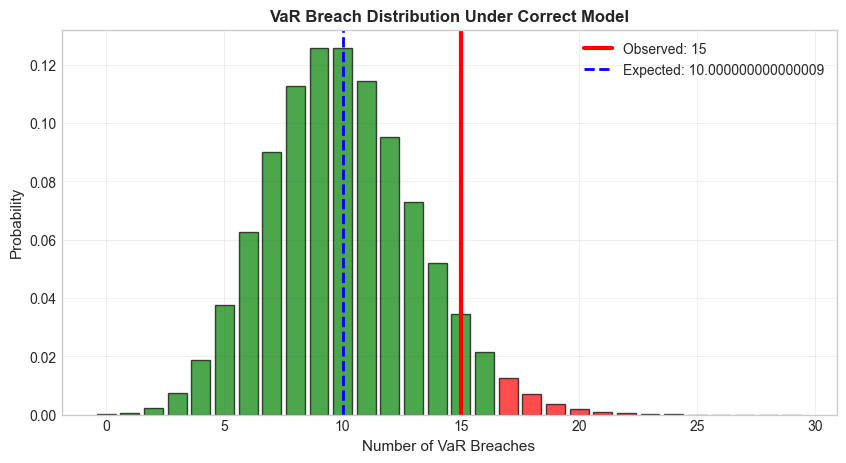


INTERPRETATION:
  15 breaches is 1.6 std above expected
  Model likely underestimates tail risk (fat tails not captured)


In [7]:
# ANSWER: VaR Backtest
print("=" * 60)
print("QUESTION 6: VaR Model Validation")
print("=" * 60)

n_days = 1000
n_breaches = 15
var_level = 0.99
expected_breaches = n_days * (1 - var_level)  # 10 expected

print(f"\nData:")
print(f"  Trading days: {n_days}")
print(f"  VaR breaches: {n_breaches}")
print(f"  Expected (99% VaR): {expected_breaches}")

# Kupiec POF Test (Proportion of Failures)
# Under H0: breaches ~ Binomial(n, 1-VaR_level)
p_value = 1 - stats.binom.cdf(n_breaches - 1, n_days, 1 - var_level)

print(f"\nKupiec POF Test:")
print(f"  H0: Model is correctly specified")
print(f"  P(≥{n_breaches} breaches | correct model): {p_value:.4f}")
print(f"  Conclusion: {'Reject H0 - Model underestimates risk' if p_value < 0.05 else 'Cannot reject H0'}")

# Visual
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(0, 30)
pmf = stats.binom.pmf(x, n_days, 1 - var_level)
colors = ['green' if xi <= expected_breaches + 2*np.sqrt(n_days*0.01*0.99) else 'red' for xi in x]
ax.bar(x, pmf, color=colors, alpha=0.7, edgecolor='black')
ax.axvline(n_breaches, color='red', lw=3, label=f'Observed: {n_breaches}')
ax.axvline(expected_breaches, color='blue', lw=2, linestyle='--', label=f'Expected: {expected_breaches}')
ax.set_xlabel('Number of VaR Breaches', fontsize=11)
ax.set_ylabel('Probability', fontsize=11)
ax.set_title('VaR Breach Distribution Under Correct Model', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(f"\nINTERPRETATION:")
print(f"  15 breaches is {(n_breaches - expected_breaches) / np.sqrt(n_days * 0.01 * 0.99):.1f} std above expected")
print(f"  Model likely underestimates tail risk (fat tails not captured)")

---
## Quick-Fire Review Questions

In [8]:
print("=" * 60)
print("QUICK-FIRE REVIEW")
print("=" * 60)

qa_pairs = [
    ("Q: What does excess kurtosis measure?",
     "A: Tail thickness relative to Normal. >0 = fat tails."),
    
    ("Q: Why use ddof=1 for sample variance?",
     "A: Bessel's correction - makes estimator unbiased."),
    
    ("Q: What's the Sharpe ratio formula?",
     "A: (Return - Risk-free) / Volatility"),
    
    ("Q: Why correlate returns, not prices?",
     "A: Prices are non-stationary → spurious correlations."),
    
    ("Q: What does p-value = 0.03 mean?",
     "A: 3% chance of seeing data this extreme if H0 is true."),
    
    ("Q: Difference between Type I and Type II error?",
     "A: Type I = False positive (reject true H0)\n   Type II = False negative (fail to reject false H0)"),
    
    ("Q: What's the CLT and why does it matter?",
     "A: Sample means → Normal as n→∞. Enables hypothesis testing."),
    
    ("Q: Confidence vs Credible interval?",
     "A: Confidence = 95% of intervals contain true value\n   Credible = 95% probability true value is in interval"),
    
    ("Q: What is tail dependence?",
     "A: Tendency for extreme events to occur together (correlations increase in crashes)."),
    
    ("Q: Annualize daily volatility?",
     "A: Multiply by √252")
]

for q, a in qa_pairs:
    print(f"\n{q}")
    print(f"{a}")
    print("-" * 50)

QUICK-FIRE REVIEW

Q: What does excess kurtosis measure?
A: Tail thickness relative to Normal. >0 = fat tails.
--------------------------------------------------

Q: Why use ddof=1 for sample variance?
A: Bessel's correction - makes estimator unbiased.
--------------------------------------------------

Q: What's the Sharpe ratio formula?
A: (Return - Risk-free) / Volatility
--------------------------------------------------

Q: Why correlate returns, not prices?
A: Prices are non-stationary → spurious correlations.
--------------------------------------------------

Q: What does p-value = 0.03 mean?
A: 3% chance of seeing data this extreme if H0 is true.
--------------------------------------------------

Q: Difference between Type I and Type II error?
A: Type I = False positive (reject true H0)
   Type II = False negative (fail to reject false H0)
--------------------------------------------------

Q: What's the CLT and why does it matter?
A: Sample means → Normal as n→∞. Enables hyp

---
## 📝 Week 2 Summary

### Day 1: Probability Distributions
- Normal, Student-t, Log-Normal
- Fat tails in finance
- VaR under different assumptions

### Day 2: Moments & Descriptive Statistics
- Mean, Variance, Skewness, Kurtosis
- Rolling statistics for regime detection
- Risk-adjusted metrics (Sharpe, Sortino)

### Day 3: Hypothesis Testing
- t-tests, chi-square tests
- Testing strategy significance
- Multiple testing problem

### Day 4: Correlation & Dependence
- Pearson, Spearman, Kendall
- Rolling correlation
- Tail dependence

### Day 5: CLT & Confidence Intervals
- Central Limit Theorem
- Bootstrap methods
- Sample size requirements

### Day 6: Bayesian Thinking
- Bayes' theorem
- Prior, Likelihood, Posterior
- Bayesian vs Frequentist

### Day 7: Interview Prep
- Common questions
- Problem-solving approaches
- Quick-fire review

## 🔴 PROS & CONS: Interview Questions

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.